# $Q$-learning on cartpole
Below, we run the $Q$-learning algorithm on the cartpole example.
* [You can read about the cartpole problem here](cartpole.ipynb)
* [You can read about $Q$-learning here.](q_notebook.ipynb)
* [You can see the pure code for $Q$-learning on cartpole here.](./cartpole/q_on_cartpole.py)

## Summary of the algorithm
We build a (deep) network to represent $Q(s,a)$= `network(state)`

```
network = keras.Sequential([
        keras.layers.Dense(30, input_dim=n_s, activation='relu'),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(n_a)])
        
self.network.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
```

Then, we iteratively improve the network. In each iteration of the algorithm, we do the following
* i. We rollout the environment to collect data for $Q$-learning by following these steps:
    * i.a. We initialize empty histories for `states=[]`, `actions=[]`, `rewards=[]`, `next_states=[]`, `dones=[]`.
    * i.b. We observe the `state` $s$ and select the `action` $a$ according to
    
    ```
    if np.random.random() <= epsilon:
        selected_action = env.action_space.sample()
    else:
        selected_action = np.argmax(self.network(state))
    ```
 
    * i.c. We derive the environment using $a$ and observe the `reward` $r$, the next state $s^{\prime}$, and the boolean $done$ (which is `True` if the episode has ended and `False` otherwise).
    * i.d. We add $s,\:a,\:r,\:s^{\prime},\:done$ to the history batch `states`, `actions`, `rewards`, `next_states`, `dones`.
    * i.e. We continue from i.b. until the episode ends.
* ii. We supply `states`, `actions`, `rewards`, `next_states`, `dones` to the network and optimize the parameters of the network.

```
eps_length = len(states)
states = np.vstack(states)
q_target = self.network(states).numpy

for i in range(eps_length):

    if dones[i]:
        q_target[i, actions[i]] = rewards[i]
    else:
        q_target[i, actions[i]] = rewards[i] + Gamma * tf.math.reduce_max(network(next_states[i])).numpy()

loss = self.network.train_on_batch(states, q_target)
```

## Running on google colab
If you want to run on google colab, go ahead and run the following cell. If you want to run on your computer, skip this cell and start from Importing libraries.

In [ ]:
!git clone https://github.com/FarnazAdib/Crash_course_on_RL.git
%cd Crash_course_on_RL
!pip install .

## Importing libraries
We start coding by importing the required libraries. If you get an error, you have possibly forgotten to change the kernel. See [Prepare a virtual environment](Preparation.ipynb).

In [1]:
import numpy as np
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow import keras
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from cartpole.dynamics import CartPole
from cartpole.pltlib import PLTLIB

## Saving directories
Next, we set up some paths to write data and capture some videos for future investigation.

In [2]:
STORE_PATH = '/tmp/cartpole_exp1/Q'
data_path = STORE_PATH + f"/data_{dt.datetime.now().strftime('%d%m%Y%H%M')}"
agent_path = STORE_PATH + f"/agent_{dt.datetime.now().strftime('%d%m%Y%H%M')}"
train_writer = tf.summary.create_file_writer(data_path)

## Making the environment
We select the random seed and make the cartpole environment.


In [3]:
Rand_Seed = 1
env_par = {
    'Rand_Seed': Rand_Seed,
    'STORE_PATH': STORE_PATH,
    'monitor': False,
    'threshold': 195.0
}
Rand_Seed = 1
CP = CartPole(env_par)


## Making the $Q$-learning agent
We define the $Q$ learning class. This class builds a network representing $Q(s,a)$. The parameter vector $\theta$ is the weights and biases in the network. The network has a structure which you can see in Q class. `hidden_size` denotes the number of nodes in the layers of the network. `GAMMA`is the discount factor $0\leq \gamma \leq 1$ quantifies how much we care about the immediate rewards and future rewards. We update the parameter vector $\theta$ by an ADAM optimizer which is a gradient algorithm. `learning_rate_adam`is the learning rate in ADAM optimizer is usually in $[0.0001,\:0.1]$. `adam_eps` is another hyperparameter to tune in ADAM algorithm. 



In [4]:
class Q:
    def __init__(self, hparams):
        self.hparams = hparams
        np.random.seed(hparams['Rand_Seed'])
        tf.random.set_seed(hparams['Rand_Seed'])
        self.epsilon = hparams['epsilon']
        
        # The Q network. Feel free to change the structure of the Q network. Remember the structure below is not
        # the best one. It is the one that gives the result in this notebook.
        self.network = keras.Sequential([
            keras.layers.Dense(self.hparams['hidden_size'], input_dim=self.hparams['num_state'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['hidden_size'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['hidden_size'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['num_actions'], dtype='float64')
        ])

        # The cost function for the Q network
        self.network.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(
            epsilon=self.hparams['adam_eps'], learning_rate=self.hparams['learning_rate_adam']))
    
    
    def get_action(self, state, env):
        state = self._process_state(state)
        
        # Exploration
        if np.random.random() <= self.epsilon:
            selected_action = env.action_space.sample()
        
        # Exploitation
        else:
            selected_action = np.argmax(self.network(state))
        return selected_action
    
    def update_network(self, states, actions, rewards, next_states, dones):
        eps_length = len(states)
        states = np.vstack(states)
        q_target = self.network(states).numpy()
        for i in range(eps_length):
            if dones[i]:
                q_target[i, actions[i]] = rewards[i]
            else:
                next_state = self._process_state(next_states[i])
                q_target[i, actions[i]] = rewards[i] + \
                                        self.hparams['GAMMA'] * tf.math.reduce_max(self.network(next_state)).numpy()
        loss = self.network.train_on_batch(states, q_target)
        return loss
    
    def _process_state(self, state):
        return state.reshape([1, self.hparams['num_state']])
    

We have configured our network, by selecting the structure and cost function to be minmized. The last step is to feed the network with `states`, `actions`, `next_states`, and `dones` and update the parameters of the network. This is done by the function `update_network(self, states, actions, rewards, next_states, dones)`.

Now that we have defined the $Q$-learning algorithm, it is enough to build an object and to iterate. You can change the following hyper parameters if you like

* `hidden_size`: Number of nodes in the layers.
* `GAMMA`: forgetting factor in the total cost. It should be in $[0\:1]$.
* `num_episodes`: The maximum number of episodes to run.
* `epsilon`: The probability of exploration. It should be in $(0\:1)$.
* `learning_rate_adam`: The learning rate for adam optimization.
* `adam_eps`: The epsilon in adam optimization.

In [5]:
agent_par = {
    'num_state': CP.env.observation_space.shape[0],
    'num_actions': CP.env.action_space.n,
    'Rand_Seed': Rand_Seed,
    'hidden_size': 30,
    'GAMMA': 1.0,
    'num_episodes': 5000,
    'epsilon': 0.1, 
    'learning_rate_adam': 0.001,
    'adam_eps': 0.1,
}
policy = Q(agent_par)


## Start learning
Now, we start the learning loop. The learning loop iterates for a maximum of number `num_episodes`. In each iteration
* The agent derives the environment for one episode to collect data for $Q$-learning.
* We update the $Q$ network using the recorded data.
* We check if the problem is solved.
* We write the data.
At the end of the learning loop, we close the environment.

In [6]:
tot_rews = []
mean_100ep = 0
for episode in range(agent_par['num_episodes']):

    # Do one rollout
    states, actions, rewards, new_states, dones = CP.one_rollout(policy)

    # Update the agent
    loss = policy.update_network(states, actions, rewards, new_states, dones)

    # Check if the problem is solved
    if episode > 100:
        mean_100ep = np.mean(tot_rews[-101:-1])

    tot_reward = sum(rewards)
    tot_rews.append(tot_reward)
    print(f"Episode: {episode}, Reward: {tot_reward}, Mean of 100 cons episodes: {mean_100ep}")
    if mean_100ep > env_par['threshold']:
        print(f"Problem is  solved.")
        policy.network.save(agent_path)
        break

    # Save data
    with train_writer.as_default():
        tf.summary.scalar('reward', tot_reward, step=episode)

# Close the environment
CP.env.close()

# Print the summary of the solution
if mean_100ep > env_par['threshold']:
    print(f"\n\nProblem is solved after {episode} Episode with the mean reward {mean_100ep} over the last 100 episodes")


Episode: 0, Reward: 11.0, Mean of 100 cons episodes: 0
Episode: 1, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 2, Reward: 16.0, Mean of 100 cons episodes: 0
Episode: 3, Reward: 8.0, Mean of 100 cons episodes: 0
Episode: 4, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 5, Reward: 9.0, Mean of 100 cons episodes: 0
Episode: 6, Reward: 9.0, Mean of 100 cons episodes: 0
Episode: 7, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 8, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 9, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 10, Reward: 11.0, Mean of 100 cons episodes: 0
Episode: 11, Reward: 8.0, Mean of 100 cons episodes: 0
Episode: 12, Reward: 13.0, Mean of 100 cons episodes: 0
Episode: 13, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 14, Reward: 8.0, Mean of 100 cons episodes: 0
Episode: 15, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 16, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 17, Reward: 10.0, Mean of 100 cons episodes: 0
Episode

Episode: 145, Reward: 8.0, Mean of 100 cons episodes: 9.79
Episode: 146, Reward: 9.0, Mean of 100 cons episodes: 9.78
Episode: 147, Reward: 8.0, Mean of 100 cons episodes: 9.76
Episode: 148, Reward: 16.0, Mean of 100 cons episodes: 9.75
Episode: 149, Reward: 9.0, Mean of 100 cons episodes: 9.75
Episode: 150, Reward: 8.0, Mean of 100 cons episodes: 9.79
Episode: 151, Reward: 10.0, Mean of 100 cons episodes: 9.79
Episode: 152, Reward: 10.0, Mean of 100 cons episodes: 9.78
Episode: 153, Reward: 10.0, Mean of 100 cons episodes: 9.8
Episode: 154, Reward: 9.0, Mean of 100 cons episodes: 9.76
Episode: 155, Reward: 10.0, Mean of 100 cons episodes: 9.76
Episode: 156, Reward: 12.0, Mean of 100 cons episodes: 9.77
Episode: 157, Reward: 9.0, Mean of 100 cons episodes: 9.77
Episode: 158, Reward: 10.0, Mean of 100 cons episodes: 9.78
Episode: 159, Reward: 8.0, Mean of 100 cons episodes: 9.76
Episode: 160, Reward: 12.0, Mean of 100 cons episodes: 9.77
Episode: 161, Reward: 10.0, Mean of 100 cons epis

Episode: 283, Reward: 10.0, Mean of 100 cons episodes: 9.77
Episode: 284, Reward: 10.0, Mean of 100 cons episodes: 9.77
Episode: 285, Reward: 8.0, Mean of 100 cons episodes: 9.78
Episode: 286, Reward: 9.0, Mean of 100 cons episodes: 9.78
Episode: 287, Reward: 10.0, Mean of 100 cons episodes: 9.76
Episode: 288, Reward: 8.0, Mean of 100 cons episodes: 9.75
Episode: 289, Reward: 10.0, Mean of 100 cons episodes: 9.75
Episode: 290, Reward: 11.0, Mean of 100 cons episodes: 9.75
Episode: 291, Reward: 10.0, Mean of 100 cons episodes: 9.74
Episode: 292, Reward: 9.0, Mean of 100 cons episodes: 9.76
Episode: 293, Reward: 12.0, Mean of 100 cons episodes: 9.76
Episode: 294, Reward: 9.0, Mean of 100 cons episodes: 9.76
Episode: 295, Reward: 10.0, Mean of 100 cons episodes: 9.77
Episode: 296, Reward: 8.0, Mean of 100 cons episodes: 9.76
Episode: 297, Reward: 10.0, Mean of 100 cons episodes: 9.76
Episode: 298, Reward: 10.0, Mean of 100 cons episodes: 9.74
Episode: 299, Reward: 9.0, Mean of 100 cons ep

Episode: 422, Reward: 12.0, Mean of 100 cons episodes: 9.8
Episode: 423, Reward: 8.0, Mean of 100 cons episodes: 9.82
Episode: 424, Reward: 10.0, Mean of 100 cons episodes: 9.85
Episode: 425, Reward: 9.0, Mean of 100 cons episodes: 9.83
Episode: 426, Reward: 9.0, Mean of 100 cons episodes: 9.84
Episode: 427, Reward: 12.0, Mean of 100 cons episodes: 9.85
Episode: 428, Reward: 12.0, Mean of 100 cons episodes: 9.85
Episode: 429, Reward: 10.0, Mean of 100 cons episodes: 9.88
Episode: 430, Reward: 12.0, Mean of 100 cons episodes: 9.89
Episode: 431, Reward: 10.0, Mean of 100 cons episodes: 9.89
Episode: 432, Reward: 11.0, Mean of 100 cons episodes: 9.92
Episode: 433, Reward: 10.0, Mean of 100 cons episodes: 9.92
Episode: 434, Reward: 8.0, Mean of 100 cons episodes: 9.94
Episode: 435, Reward: 10.0, Mean of 100 cons episodes: 9.94
Episode: 436, Reward: 10.0, Mean of 100 cons episodes: 9.87
Episode: 437, Reward: 8.0, Mean of 100 cons episodes: 9.88
Episode: 438, Reward: 9.0, Mean of 100 cons ep

Episode: 558, Reward: 12.0, Mean of 100 cons episodes: 10.9
Episode: 559, Reward: 10.0, Mean of 100 cons episodes: 10.89
Episode: 560, Reward: 10.0, Mean of 100 cons episodes: 10.9
Episode: 561, Reward: 10.0, Mean of 100 cons episodes: 10.89
Episode: 562, Reward: 9.0, Mean of 100 cons episodes: 10.87
Episode: 563, Reward: 13.0, Mean of 100 cons episodes: 10.88
Episode: 564, Reward: 11.0, Mean of 100 cons episodes: 10.85
Episode: 565, Reward: 11.0, Mean of 100 cons episodes: 10.88
Episode: 566, Reward: 14.0, Mean of 100 cons episodes: 10.87
Episode: 567, Reward: 17.0, Mean of 100 cons episodes: 10.86
Episode: 568, Reward: 13.0, Mean of 100 cons episodes: 10.88
Episode: 569, Reward: 13.0, Mean of 100 cons episodes: 10.94
Episode: 570, Reward: 14.0, Mean of 100 cons episodes: 10.94
Episode: 571, Reward: 17.0, Mean of 100 cons episodes: 10.96
Episode: 572, Reward: 17.0, Mean of 100 cons episodes: 11.0
Episode: 573, Reward: 19.0, Mean of 100 cons episodes: 11.06
Episode: 574, Reward: 17.0, 

Episode: 693, Reward: 11.0, Mean of 100 cons episodes: 23.35
Episode: 694, Reward: 13.0, Mean of 100 cons episodes: 23.3
Episode: 695, Reward: 15.0, Mean of 100 cons episodes: 23.15
Episode: 696, Reward: 15.0, Mean of 100 cons episodes: 23.04
Episode: 697, Reward: 16.0, Mean of 100 cons episodes: 23.02
Episode: 698, Reward: 18.0, Mean of 100 cons episodes: 22.9
Episode: 699, Reward: 18.0, Mean of 100 cons episodes: 22.8
Episode: 700, Reward: 18.0, Mean of 100 cons episodes: 22.7
Episode: 701, Reward: 18.0, Mean of 100 cons episodes: 22.6
Episode: 702, Reward: 22.0, Mean of 100 cons episodes: 22.51
Episode: 703, Reward: 21.0, Mean of 100 cons episodes: 22.43
Episode: 704, Reward: 22.0, Mean of 100 cons episodes: 22.35
Episode: 705, Reward: 22.0, Mean of 100 cons episodes: 22.21
Episode: 706, Reward: 18.0, Mean of 100 cons episodes: 22.13
Episode: 707, Reward: 25.0, Mean of 100 cons episodes: 22.07
Episode: 708, Reward: 27.0, Mean of 100 cons episodes: 21.93
Episode: 709, Reward: 18.0, M

Episode: 826, Reward: 48.0, Mean of 100 cons episodes: 107.21
Episode: 827, Reward: 56.0, Mean of 100 cons episodes: 107.64
Episode: 828, Reward: 58.0, Mean of 100 cons episodes: 107.77
Episode: 829, Reward: 172.0, Mean of 100 cons episodes: 107.99
Episode: 830, Reward: 46.0, Mean of 100 cons episodes: 108.14
Episode: 831, Reward: 53.0, Mean of 100 cons episodes: 109.46
Episode: 832, Reward: 57.0, Mean of 100 cons episodes: 109.1
Episode: 833, Reward: 59.0, Mean of 100 cons episodes: 109.08
Episode: 834, Reward: 87.0, Mean of 100 cons episodes: 109.09
Episode: 835, Reward: 53.0, Mean of 100 cons episodes: 109.17
Episode: 836, Reward: 60.0, Mean of 100 cons episodes: 109.26
Episode: 837, Reward: 67.0, Mean of 100 cons episodes: 109.17
Episode: 838, Reward: 70.0, Mean of 100 cons episodes: 109.18
Episode: 839, Reward: 52.0, Mean of 100 cons episodes: 109.26
Episode: 840, Reward: 200.0, Mean of 100 cons episodes: 109.13
Episode: 841, Reward: 127.0, Mean of 100 cons episodes: 108.82
Episod

Episode: 960, Reward: 45.0, Mean of 100 cons episodes: 30.63
Episode: 961, Reward: 39.0, Mean of 100 cons episodes: 30.47
Episode: 962, Reward: 42.0, Mean of 100 cons episodes: 30.32
Episode: 963, Reward: 60.0, Mean of 100 cons episodes: 30.18
Episode: 964, Reward: 53.0, Mean of 100 cons episodes: 29.96
Episode: 965, Reward: 54.0, Mean of 100 cons episodes: 29.96
Episode: 966, Reward: 55.0, Mean of 100 cons episodes: 30.09
Episode: 967, Reward: 140.0, Mean of 100 cons episodes: 30.09
Episode: 968, Reward: 65.0, Mean of 100 cons episodes: 30.26
Episode: 969, Reward: 64.0, Mean of 100 cons episodes: 30.9
Episode: 970, Reward: 44.0, Mean of 100 cons episodes: 31.18
Episode: 971, Reward: 134.0, Mean of 100 cons episodes: 31.38
Episode: 972, Reward: 52.0, Mean of 100 cons episodes: 31.38
Episode: 973, Reward: 51.0, Mean of 100 cons episodes: 32.43
Episode: 974, Reward: 59.0, Mean of 100 cons episodes: 32.71
Episode: 975, Reward: 92.0, Mean of 100 cons episodes: 32.95
Episode: 976, Reward: 5

Episode: 1093, Reward: 19.0, Mean of 100 cons episodes: 28.7
Episode: 1094, Reward: 19.0, Mean of 100 cons episodes: 28.52
Episode: 1095, Reward: 21.0, Mean of 100 cons episodes: 28.31
Episode: 1096, Reward: 20.0, Mean of 100 cons episodes: 27.83
Episode: 1097, Reward: 25.0, Mean of 100 cons episodes: 27.66
Episode: 1098, Reward: 19.0, Mean of 100 cons episodes: 27.34
Episode: 1099, Reward: 23.0, Mean of 100 cons episodes: 27.1
Episode: 1100, Reward: 25.0, Mean of 100 cons episodes: 26.85
Episode: 1101, Reward: 25.0, Mean of 100 cons episodes: 26.73
Episode: 1102, Reward: 22.0, Mean of 100 cons episodes: 26.53
Episode: 1103, Reward: 25.0, Mean of 100 cons episodes: 26.54
Episode: 1104, Reward: 23.0, Mean of 100 cons episodes: 26.39
Episode: 1105, Reward: 21.0, Mean of 100 cons episodes: 26.34
Episode: 1106, Reward: 24.0, Mean of 100 cons episodes: 26.28
Episode: 1107, Reward: 22.0, Mean of 100 cons episodes: 26.23
Episode: 1108, Reward: 20.0, Mean of 100 cons episodes: 26.17
Episode: 1

Episode: 1226, Reward: 48.0, Mean of 100 cons episodes: 27.53
Episode: 1227, Reward: 61.0, Mean of 100 cons episodes: 27.86
Episode: 1228, Reward: 59.0, Mean of 100 cons episodes: 28.07
Episode: 1229, Reward: 49.0, Mean of 100 cons episodes: 28.42
Episode: 1230, Reward: 52.0, Mean of 100 cons episodes: 28.79
Episode: 1231, Reward: 41.0, Mean of 100 cons episodes: 28.98
Episode: 1232, Reward: 58.0, Mean of 100 cons episodes: 29.16
Episode: 1233, Reward: 78.0, Mean of 100 cons episodes: 29.37
Episode: 1234, Reward: 53.0, Mean of 100 cons episodes: 29.71
Episode: 1235, Reward: 37.0, Mean of 100 cons episodes: 30.26
Episode: 1236, Reward: 57.0, Mean of 100 cons episodes: 30.5
Episode: 1237, Reward: 42.0, Mean of 100 cons episodes: 30.61
Episode: 1238, Reward: 43.0, Mean of 100 cons episodes: 30.92
Episode: 1239, Reward: 46.0, Mean of 100 cons episodes: 31.03
Episode: 1240, Reward: 44.0, Mean of 100 cons episodes: 31.19
Episode: 1241, Reward: 53.0, Mean of 100 cons episodes: 31.4
Episode: 1

Episode: 1358, Reward: 46.0, Mean of 100 cons episodes: 74.86
Episode: 1359, Reward: 35.0, Mean of 100 cons episodes: 74.99
Episode: 1360, Reward: 36.0, Mean of 100 cons episodes: 75.21
Episode: 1361, Reward: 36.0, Mean of 100 cons episodes: 75.36
Episode: 1362, Reward: 42.0, Mean of 100 cons episodes: 75.52
Episode: 1363, Reward: 46.0, Mean of 100 cons episodes: 75.71
Episode: 1364, Reward: 35.0, Mean of 100 cons episodes: 75.92
Episode: 1365, Reward: 42.0, Mean of 100 cons episodes: 76.23
Episode: 1366, Reward: 42.0, Mean of 100 cons episodes: 76.4
Episode: 1367, Reward: 45.0, Mean of 100 cons episodes: 76.63
Episode: 1368, Reward: 27.0, Mean of 100 cons episodes: 76.83
Episode: 1369, Reward: 24.0, Mean of 100 cons episodes: 77.07
Episode: 1370, Reward: 34.0, Mean of 100 cons episodes: 77.16
Episode: 1371, Reward: 24.0, Mean of 100 cons episodes: 77.26
Episode: 1372, Reward: 30.0, Mean of 100 cons episodes: 77.46
Episode: 1373, Reward: 28.0, Mean of 100 cons episodes: 77.54
Episode: 

Episode: 1491, Reward: 61.0, Mean of 100 cons episodes: 70.04
Episode: 1492, Reward: 60.0, Mean of 100 cons episodes: 70.34
Episode: 1493, Reward: 45.0, Mean of 100 cons episodes: 70.64
Episode: 1494, Reward: 77.0, Mean of 100 cons episodes: 70.98
Episode: 1495, Reward: 66.0, Mean of 100 cons episodes: 71.02
Episode: 1496, Reward: 70.0, Mean of 100 cons episodes: 71.38
Episode: 1497, Reward: 69.0, Mean of 100 cons episodes: 71.72
Episode: 1498, Reward: 85.0, Mean of 100 cons episodes: 71.97
Episode: 1499, Reward: 59.0, Mean of 100 cons episodes: 72.16
Episode: 1500, Reward: 72.0, Mean of 100 cons episodes: 72.33
Episode: 1501, Reward: 71.0, Mean of 100 cons episodes: 72.41
Episode: 1502, Reward: 77.0, Mean of 100 cons episodes: 72.67
Episode: 1503, Reward: 83.0, Mean of 100 cons episodes: 72.71
Episode: 1504, Reward: 84.0, Mean of 100 cons episodes: 72.93
Episode: 1505, Reward: 82.0, Mean of 100 cons episodes: 72.91
Episode: 1506, Reward: 78.0, Mean of 100 cons episodes: 72.8
Episode: 

Episode: 1624, Reward: 40.0, Mean of 100 cons episodes: 71.53
Episode: 1625, Reward: 37.0, Mean of 100 cons episodes: 71.26
Episode: 1626, Reward: 97.0, Mean of 100 cons episodes: 70.87
Episode: 1627, Reward: 92.0, Mean of 100 cons episodes: 70.35
Episode: 1628, Reward: 41.0, Mean of 100 cons episodes: 70.62
Episode: 1629, Reward: 100.0, Mean of 100 cons episodes: 70.85
Episode: 1630, Reward: 33.0, Mean of 100 cons episodes: 70.67
Episode: 1631, Reward: 103.0, Mean of 100 cons episodes: 71.08
Episode: 1632, Reward: 26.0, Mean of 100 cons episodes: 70.74
Episode: 1633, Reward: 89.0, Mean of 100 cons episodes: 71.19
Episode: 1634, Reward: 27.0, Mean of 100 cons episodes: 70.89
Episode: 1635, Reward: 94.0, Mean of 100 cons episodes: 71.17
Episode: 1636, Reward: 27.0, Mean of 100 cons episodes: 70.85
Episode: 1637, Reward: 91.0, Mean of 100 cons episodes: 71.17
Episode: 1638, Reward: 98.0, Mean of 100 cons episodes: 70.7
Episode: 1639, Reward: 100.0, Mean of 100 cons episodes: 71.13
Episod

Episode: 1756, Reward: 120.0, Mean of 100 cons episodes: 90.39
Episode: 1757, Reward: 70.0, Mean of 100 cons episodes: 90.39
Episode: 1758, Reward: 140.0, Mean of 100 cons episodes: 90.69
Episode: 1759, Reward: 78.0, Mean of 100 cons episodes: 90.42
Episode: 1760, Reward: 69.0, Mean of 100 cons episodes: 90.96
Episode: 1761, Reward: 67.0, Mean of 100 cons episodes: 90.71
Episode: 1762, Reward: 59.0, Mean of 100 cons episodes: 90.56
Episode: 1763, Reward: 62.0, Mean of 100 cons episodes: 90.19
Episode: 1764, Reward: 62.0, Mean of 100 cons episodes: 90.03
Episode: 1765, Reward: 62.0, Mean of 100 cons episodes: 89.74
Episode: 1766, Reward: 73.0, Mean of 100 cons episodes: 89.43
Episode: 1767, Reward: 61.0, Mean of 100 cons episodes: 88.94
Episode: 1768, Reward: 74.0, Mean of 100 cons episodes: 88.78
Episode: 1769, Reward: 69.0, Mean of 100 cons episodes: 88.55
Episode: 1770, Reward: 51.0, Mean of 100 cons episodes: 88.45
Episode: 1771, Reward: 50.0, Mean of 100 cons episodes: 88.32
Episod

Episode: 1888, Reward: 111.0, Mean of 100 cons episodes: 85.0
Episode: 1889, Reward: 101.0, Mean of 100 cons episodes: 85.0
Episode: 1890, Reward: 100.0, Mean of 100 cons episodes: 85.51
Episode: 1891, Reward: 101.0, Mean of 100 cons episodes: 85.93
Episode: 1892, Reward: 101.0, Mean of 100 cons episodes: 85.9
Episode: 1893, Reward: 103.0, Mean of 100 cons episodes: 86.22
Episode: 1894, Reward: 126.0, Mean of 100 cons episodes: 86.41
Episode: 1895, Reward: 85.0, Mean of 100 cons episodes: 86.51
Episode: 1896, Reward: 93.0, Mean of 100 cons episodes: 87.09
Episode: 1897, Reward: 96.0, Mean of 100 cons episodes: 86.97
Episode: 1898, Reward: 99.0, Mean of 100 cons episodes: 87.23
Episode: 1899, Reward: 104.0, Mean of 100 cons episodes: 87.17
Episode: 1900, Reward: 105.0, Mean of 100 cons episodes: 87.23
Episode: 1901, Reward: 114.0, Mean of 100 cons episodes: 87.22
Episode: 1902, Reward: 102.0, Mean of 100 cons episodes: 87.61
Episode: 1903, Reward: 95.0, Mean of 100 cons episodes: 87.87


Episode: 2020, Reward: 90.0, Mean of 100 cons episodes: 97.58
Episode: 2021, Reward: 103.0, Mean of 100 cons episodes: 97.61
Episode: 2022, Reward: 96.0, Mean of 100 cons episodes: 97.69
Episode: 2023, Reward: 114.0, Mean of 100 cons episodes: 98.08
Episode: 2024, Reward: 103.0, Mean of 100 cons episodes: 98.31
Episode: 2025, Reward: 102.0, Mean of 100 cons episodes: 98.48
Episode: 2026, Reward: 101.0, Mean of 100 cons episodes: 98.7
Episode: 2027, Reward: 96.0, Mean of 100 cons episodes: 98.7
Episode: 2028, Reward: 105.0, Mean of 100 cons episodes: 98.91
Episode: 2029, Reward: 102.0, Mean of 100 cons episodes: 98.96
Episode: 2030, Reward: 100.0, Mean of 100 cons episodes: 99.53
Episode: 2031, Reward: 99.0, Mean of 100 cons episodes: 99.61
Episode: 2032, Reward: 122.0, Mean of 100 cons episodes: 99.84
Episode: 2033, Reward: 110.0, Mean of 100 cons episodes: 99.83
Episode: 2034, Reward: 107.0, Mean of 100 cons episodes: 100.07
Episode: 2035, Reward: 103.0, Mean of 100 cons episodes: 100

Episode: 2149, Reward: 70.0, Mean of 100 cons episodes: 109.03
Episode: 2150, Reward: 123.0, Mean of 100 cons episodes: 109.04
Episode: 2151, Reward: 107.0, Mean of 100 cons episodes: 108.63
Episode: 2152, Reward: 117.0, Mean of 100 cons episodes: 108.77
Episode: 2153, Reward: 115.0, Mean of 100 cons episodes: 108.72
Episode: 2154, Reward: 118.0, Mean of 100 cons episodes: 108.83
Episode: 2155, Reward: 116.0, Mean of 100 cons episodes: 108.94
Episode: 2156, Reward: 113.0, Mean of 100 cons episodes: 109.13
Episode: 2157, Reward: 121.0, Mean of 100 cons episodes: 109.17
Episode: 2158, Reward: 134.0, Mean of 100 cons episodes: 109.21
Episode: 2159, Reward: 112.0, Mean of 100 cons episodes: 109.39
Episode: 2160, Reward: 111.0, Mean of 100 cons episodes: 109.52
Episode: 2161, Reward: 109.0, Mean of 100 cons episodes: 109.53
Episode: 2162, Reward: 111.0, Mean of 100 cons episodes: 109.63
Episode: 2163, Reward: 117.0, Mean of 100 cons episodes: 109.62
Episode: 2164, Reward: 119.0, Mean of 100

Episode: 2278, Reward: 130.0, Mean of 100 cons episodes: 112.51
Episode: 2279, Reward: 152.0, Mean of 100 cons episodes: 112.69
Episode: 2280, Reward: 104.0, Mean of 100 cons episodes: 112.71
Episode: 2281, Reward: 110.0, Mean of 100 cons episodes: 113.22
Episode: 2282, Reward: 121.0, Mean of 100 cons episodes: 113.13
Episode: 2283, Reward: 115.0, Mean of 100 cons episodes: 113.2
Episode: 2284, Reward: 127.0, Mean of 100 cons episodes: 113.31
Episode: 2285, Reward: 100.0, Mean of 100 cons episodes: 113.46
Episode: 2286, Reward: 117.0, Mean of 100 cons episodes: 113.63
Episode: 2287, Reward: 112.0, Mean of 100 cons episodes: 113.64
Episode: 2288, Reward: 118.0, Mean of 100 cons episodes: 113.83
Episode: 2289, Reward: 114.0, Mean of 100 cons episodes: 113.77
Episode: 2290, Reward: 107.0, Mean of 100 cons episodes: 113.9
Episode: 2291, Reward: 101.0, Mean of 100 cons episodes: 113.92
Episode: 2292, Reward: 110.0, Mean of 100 cons episodes: 113.96
Episode: 2293, Reward: 93.0, Mean of 100 c

Episode: 2407, Reward: 118.0, Mean of 100 cons episodes: 112.38
Episode: 2408, Reward: 98.0, Mean of 100 cons episodes: 112.46
Episode: 2409, Reward: 101.0, Mean of 100 cons episodes: 112.74
Episode: 2410, Reward: 112.0, Mean of 100 cons episodes: 112.89
Episode: 2411, Reward: 88.0, Mean of 100 cons episodes: 113.02
Episode: 2412, Reward: 123.0, Mean of 100 cons episodes: 113.34
Episode: 2413, Reward: 115.0, Mean of 100 cons episodes: 113.2
Episode: 2414, Reward: 121.0, Mean of 100 cons episodes: 113.61
Episode: 2415, Reward: 95.0, Mean of 100 cons episodes: 113.85
Episode: 2416, Reward: 120.0, Mean of 100 cons episodes: 114.08
Episode: 2417, Reward: 88.0, Mean of 100 cons episodes: 114.1
Episode: 2418, Reward: 137.0, Mean of 100 cons episodes: 114.31
Episode: 2419, Reward: 95.0, Mean of 100 cons episodes: 114.47
Episode: 2420, Reward: 94.0, Mean of 100 cons episodes: 115.14
Episode: 2421, Reward: 100.0, Mean of 100 cons episodes: 115.4
Episode: 2422, Reward: 94.0, Mean of 100 cons epi

Episode: 2536, Reward: 105.0, Mean of 100 cons episodes: 119.26
Episode: 2537, Reward: 125.0, Mean of 100 cons episodes: 119.48
Episode: 2538, Reward: 138.0, Mean of 100 cons episodes: 119.38
Episode: 2539, Reward: 110.0, Mean of 100 cons episodes: 119.6
Episode: 2540, Reward: 125.0, Mean of 100 cons episodes: 120.04
Episode: 2541, Reward: 105.0, Mean of 100 cons episodes: 119.89
Episode: 2542, Reward: 133.0, Mean of 100 cons episodes: 120.13
Episode: 2543, Reward: 111.0, Mean of 100 cons episodes: 119.62
Episode: 2544, Reward: 99.0, Mean of 100 cons episodes: 119.77
Episode: 2545, Reward: 156.0, Mean of 100 cons episodes: 119.71
Episode: 2546, Reward: 141.0, Mean of 100 cons episodes: 119.36
Episode: 2547, Reward: 97.0, Mean of 100 cons episodes: 119.73
Episode: 2548, Reward: 118.0, Mean of 100 cons episodes: 119.77
Episode: 2549, Reward: 107.0, Mean of 100 cons episodes: 119.46
Episode: 2550, Reward: 146.0, Mean of 100 cons episodes: 118.93
Episode: 2551, Reward: 124.0, Mean of 100 c

Episode: 2665, Reward: 183.0, Mean of 100 cons episodes: 132.01
Episode: 2666, Reward: 141.0, Mean of 100 cons episodes: 132.9
Episode: 2667, Reward: 173.0, Mean of 100 cons episodes: 133.46
Episode: 2668, Reward: 145.0, Mean of 100 cons episodes: 133.68
Episode: 2669, Reward: 158.0, Mean of 100 cons episodes: 134.24
Episode: 2670, Reward: 200.0, Mean of 100 cons episodes: 134.46
Episode: 2671, Reward: 147.0, Mean of 100 cons episodes: 134.95
Episode: 2672, Reward: 170.0, Mean of 100 cons episodes: 135.88
Episode: 2673, Reward: 162.0, Mean of 100 cons episodes: 135.97
Episode: 2674, Reward: 162.0, Mean of 100 cons episodes: 136.52
Episode: 2675, Reward: 159.0, Mean of 100 cons episodes: 136.99
Episode: 2676, Reward: 127.0, Mean of 100 cons episodes: 137.19
Episode: 2677, Reward: 146.0, Mean of 100 cons episodes: 137.55
Episode: 2678, Reward: 178.0, Mean of 100 cons episodes: 137.6
Episode: 2679, Reward: 133.0, Mean of 100 cons episodes: 137.42
Episode: 2680, Reward: 126.0, Mean of 100 

Episode: 2794, Reward: 200.0, Mean of 100 cons episodes: 181.81
Episode: 2795, Reward: 200.0, Mean of 100 cons episodes: 182.33
Episode: 2796, Reward: 200.0, Mean of 100 cons episodes: 182.82
Episode: 2797, Reward: 161.0, Mean of 100 cons episodes: 183.12
Episode: 2798, Reward: 200.0, Mean of 100 cons episodes: 183.45
Episode: 2799, Reward: 182.0, Mean of 100 cons episodes: 183.49
Episode: 2800, Reward: 200.0, Mean of 100 cons episodes: 184.02
Episode: 2801, Reward: 180.0, Mean of 100 cons episodes: 184.04
Episode: 2802, Reward: 200.0, Mean of 100 cons episodes: 184.44
Episode: 2803, Reward: 200.0, Mean of 100 cons episodes: 184.24
Episode: 2804, Reward: 200.0, Mean of 100 cons episodes: 184.24
Episode: 2805, Reward: 200.0, Mean of 100 cons episodes: 184.24
Episode: 2806, Reward: 200.0, Mean of 100 cons episodes: 184.24
Episode: 2807, Reward: 200.0, Mean of 100 cons episodes: 184.24
Episode: 2808, Reward: 176.0, Mean of 100 cons episodes: 184.24
Episode: 2809, Reward: 173.0, Mean of 10

## Results
It will get around 5-6 minutes to run the above cell. You will probably get some WARNING\ERROR. Some of these are related to incompatibility between some libraries. Don't panic. The problem will be solved after possibly after 2800-3000 episodes. You can see a summary of results by running the cell below. you can also see the evaluation of the rewards vs. iteration as the iteration goes on



Problem is solved after 2885 Episode with the mean reward 195.11 over the last 100 episodes


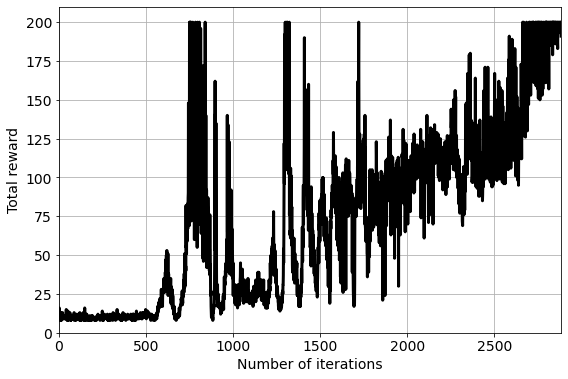

In [7]:
# Print the results if the problem is solved
if mean_100ep > env_par['threshold']:
    # Print the summary of the solution
    print(f"\n\nProblem is solved after {episode} Episode with the mean reward {mean_100ep} over the last 100 episodes")

    # Plot the result
    MyPlot = PLTLIB()
    MyPlot.reward_it(tot_rews)